### RNN : 앞선 가중치를 필요로 한다.
입력층, 은닉층, 출력층+가중치(입력층 가중치Wx, 은닉층 가중치Wh, 출력층 가중치Wy) <br />
예측값 y = tanh(Wh * ht-1 +Wx *Xt +b)<br />
             (Dh X Dh)   (Dh X 1)+(Dh X d)(dX1) +   (Dh X 1)<br />
Xt (dX1)<br />
Wx (Dh X d)<br />
Wh (Dh X Dh)<br />
ht-1  (Dh X 1)<br />
b    (Dh X 1)<br />

다대다-번역 <br/>
다대일-감정분석 <br/>
일대다-추천시스템 <br/>


CNN은 기울기를 곱해서 하나의 기울기 만드는 게 목적 <br />
RNN은 기울기를 보관하면서 앞선 기울기를 계산에 이용 =>가중치가 업데이트되는 과정에서 기울기가 1보다 작은 값이 계속 곱해지기 때문에 기울기가 사라지는 기울기 소멸 문제 발생함  ->LSTM이나 GRU <br />
LeNet의 기울기 소멸

RNN에 차분+ReLU()을 통해 성능향상 

### LSTM
torch.nn.LSTM(input_size, hidden_size, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, proj_size=0, device=None, dtype=None) <br />
input_size는 LSTM 네트워크에 입력되는 데이터의 특징(feature) 수 <br />
hidden_size가 50이라면, 각 LSTM 셀은 50차원의 벡터를 숨겨진 상태로 사용합니다. <br />
num_layers=1: 단일 LSTM 층으로 구성된 네트워크입니다.
num_layers=2: 두 개의 LSTM 층이 쌓인 네트워크로, 첫 번째 층의 출력이 두 번째 층으로 전달됩니다.

히든층 , 레이어가 너무 많으면 시간이 많이 걸린다. <br/>
오버피팅 예방위해 많은 데이터 필요<br/>
순차계산-cuda도움 못 받는다

In [1]:
#!pip install tqdm

### 스타벅스 주가 예측 (교재 410쪽)
통계적-ARIMA <br/>
AI-LSTM<br/>
둘다 전처리 필요=>다 숫자데이터야 한다.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader        #숫자데이터
from torch.autograd import Variable                           #자동미분-편미분


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
data=pd.read_csv("080289/chap07/data/SBUX.csv", index_col=["Date"], date_format="%Y-%m-%d")
data["Volume"]=data["Volume"].astype(float)
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2019-12-11 to 2020-12-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       253 non-null    float64
 1   High       253 non-null    float64
 2   Low        253 non-null    float64
 3   Close      253 non-null    float64
 4   Adj Close  253 non-null    float64
 5   Volume     253 non-null    float64
dtypes: float64(6)
memory usage: 13.8 KB


In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,84.145752,4921900.0
2019-12-12,88.000000,88.889999,87.540001,88.209999,85.720032,10282100.0
2019-12-13,88.019997,88.790001,87.580002,88.669998,86.167046,6714100.0
2019-12-16,89.139999,89.300003,88.430000,88.779999,86.273941,6705600.0
2019-12-17,88.870003,88.970001,87.470001,88.129997,85.642288,7296900.0


In [6]:
X=data.iloc[:,:-1] #컬럼은 마지막꺼 제외
y=data.iloc[:,5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [7]:
ms=MinMaxScaler()
ss=StandardScaler()

X_ss=ss.fit_transform(X)       
y_ms=ms.fit_transform(y)

X_train=X_ss[:200,:]
X_test=X_ss[200:,:]

y_train=y_ms[:200,:]
y_test=y_ms[200:,:]



In [8]:
print(X_train.shape, X_test.shape)

(200, 5) (53, 5)


In [9]:
#X_train, X_test, y_train, y_test=train_test_split(X_ss, y_ms)

### 파이토치 관련
데이터를 텐서로 변경
모델 설계
모델 생성 후 학습
예측
검증

In [10]:
X_train_tensors=Variable(torch.Tensor(X_train))
X_test_tensors=Variable(torch.Tensor(X_test))
y_train_tensors=Variable(torch.Tensor(y_train))
y_test_tensors=Variable(torch.Tensor(y_test))

In [11]:
X_test_tensors_f= torch.reshape( 
  X_test_tensors,( X_test_tensors.shape[0],1, X_test_tensors.shape[1]))
print(X_test_tensors.shape, X_test_tensors_f.shape)

X_train_tensors_f= torch.reshape( 
  X_train_tensors,( X_train_tensors.shape[0],1, X_train_tensors.shape[1]))
print(X_train_tensors.shape, X_train_tensors_f.shape)

torch.Size([53, 5]) torch.Size([53, 1, 5])
torch.Size([200, 5]) torch.Size([200, 1, 5])


In [12]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes=num_classes
        self.num_layers=num_layers
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.seq_length=seq_length

        self.lstm=nn.LSTM(input_size=input_size , hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_1=nn.Linear(hidden_size, 128)
        self.fc=nn.Linear(128, num_classes)
        self.relu=nn.ReLU()

    def forward(self, x):
        h_0=Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))         #hidden_state.shape :      torch.Size([num_layers, 배치사이즈, hidden_size])
        c_0=Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))         #cell_state.shape :    torch.Size([num_layers, 배치사이즈, hidden_size])

        output, (hn, cn) = self.lstm(x, (h_0 , c_0))
        hn=hn.view(-1, self.hidden_size)                                             #1차원조정을 위한 view(-1, )    #reshape은 원본이 바뀐다. view는 원본이 바뀌지 않는다.
        out=self.relu(hn)
        out=self.fc_1(out)
        out=self.relu(out)
        out=self.fc(out)
        return out
        
        
        
 



In [13]:
num_epochs=1000
learning_rate=0.0001

input_size=5
hidden_size=2
num_layers=1

num_classes=1
model=LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
for epoch in range(num_epochs):
    outputs=model.forward( X_train_tensors_f)
    optimizer.zero_grad()
    loss=criterion(outputs, y_train_tensors)
    loss.backward()

    optimizer.step()
    if epoch%100 == 0:
        print("Epoch:%d , loss:%1.5f" %(epoch, loss.item()))

Epoch:0 , loss:0.11030
Epoch:100 , loss:0.03592
Epoch:200 , loss:0.03276
Epoch:300 , loss:0.03054
Epoch:400 , loss:0.02818
Epoch:500 , loss:0.02606
Epoch:600 , loss:0.02419
Epoch:700 , loss:0.02248
Epoch:800 , loss:0.02109
Epoch:900 , loss:0.02012


In [15]:
# ss와 ms가 이미 정의되고 학습된 스케일러라고 가정
df_x_ss = ss.transform(data.iloc[:, :-1])  # 피처 표준화
df_y_ms = ms.transform(data.iloc[:, -1:])   # 타겟 스케일링

# numpy 배열을 PyTorch 텐서로 변환
df_x_ss = torch.Tensor(df_x_ss) 
df_y_ms = torch.Tensor(df_y_ms)

# 입력 텐서를 필요한 형태로 변경 (예: RNN용)
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))     # df_x_ss 텐서를 (샘플 수, 1, 피처 수) 형태로 변경합니다. 이는 시퀀스 데이터나 특정 입력 형태를 요구하는 모델(예: RNN)에 필요할 수 있습니다.

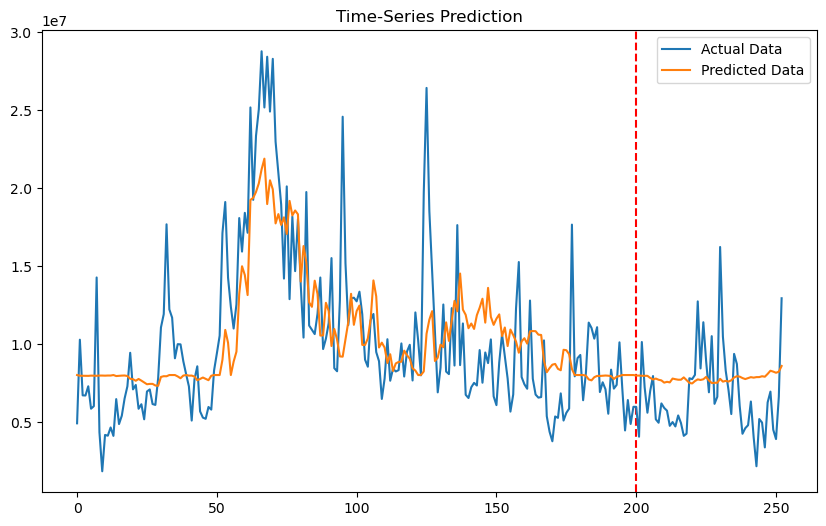

In [16]:
# 모델 예측
train_predict = model(df_x_ss)

# 텐서를 NumPy 배열로 변환
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

# 스케일링 역변환
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

# 데이터 시각화
plt.figure(figsize=(10, 6))
plt.axvline(x=200, c='r', linestyle='--')  # 시각적 분기 표시
plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()